In [1]:
from neuron import h
import numpy as np
import pylab as plt
plt.ion()

In [2]:
!nrnivmodl > null.out

/home/tnieus/mne-python/1.1.0_0/envs/neuron/bin/nrnivmodl:10: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import working_set


# Model setting

In [3]:
soma = h.Section(name='soma')
soma.L = 10
soma.diam = 10
soma.insert('sodium')
soma.insert('potassium')
soma.insert('leak')

soma

In [4]:
print(soma.gl_leak)

0.0003


## Set active channels off

In [5]:
soma.gnabar_sodium = 0
soma.gkbar_potassium = 0
soma.gl_leak = 0.0003

In [29]:
tstop = 5500
onset = 100
dur = tstop - 2 * onset

## Define inputs

In [30]:
# step current
iclamp = h.IClamp(soma(0.5))
iclamp.delay = onset
iclamp.dur = dur
iclamp.amp = 0 # 0.9

# sinusoidal current
sin_input = h.GrC_Sine(soma(0.5))
sin_input.delay = onset
sin_input.dur = 4800 #dur
sin_input.amp = 0.006
sin_input.freq = 0.2 #10
sin_input.phase = 0 

# record voltage and time
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# Run simulation

In [31]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
h.tstop = tstop
h.run()

0.0

Text(0, 0.5, 'v (mV)')

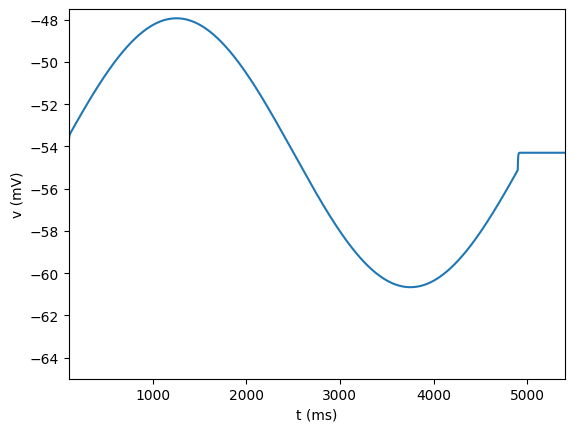

In [32]:
v_arr = np.array(v)
t_arr = np.array(t)

plt.figure()
plt.plot(t_arr, v_arr)
plt.xlim(onset, onset+dur)
plt.ylim(-65, -47.5)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')

In [33]:
idx_t = np.where((t_arr>onset)&(t_arr<(onset+dur)))[0]
print(v_arr[idx_t].max()-v_arr[idx_t].min())

12.732282910149152


# Investigate low pass filtering

In [34]:
freqs = [0.2, 0.5, 5, 10, 20, 50, 100, 300, 500] # 0.1, 
delta_v = []
for freq in freqs:    
    sin_input.freq = freq
    h.tstop = 2 * onset + 1000 / freq
    h.run()
    v_arr = np.array(v)
    t_arr = np.array(t)
    idx_t = np.where((t_arr>onset)&(t_arr<(onset+dur)))[0]
    dv = v_arr[idx_t].max()-v_arr[idx_t].min()
    delta_v.append(dv)
    print(freq, dv)

0.2 12.732282910149152
0.5 12.731692138372622
5 12.662635919163556
10 12.460315363626222
20 11.758434772464383
50 9.118127240340549
100 6.174360285626896
300 2.61242187188531
500 1.6569185907658692


In [35]:
delta_v = np.array(delta_v)
delta_v.max()

12.732282910149152

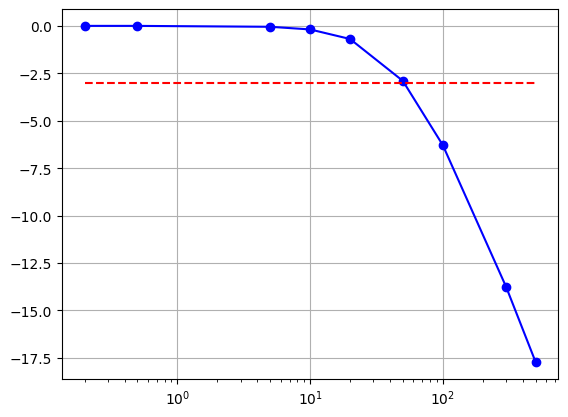

In [36]:
delta_v = np.array(delta_v)
delta_v = 20 * np.log10(delta_v/delta_v.max())
plt.plot(freqs, delta_v, marker='o', ls='-', c='blue')
plt.plot([freqs[0],freqs[-1]],[-3,-3],'r--')
plt.grid()
plt.xscale('log')

In [37]:
# cm = 1 uF/cm2, rm = 1/gl_leak S/cm2
tau_cut_off = soma.cm * (1/soma.gl_leak) * 1e-6
freq_cut_off = 1/(2*np.pi*tau_cut_off)
print(freq_cut_off)

47.7464829275686


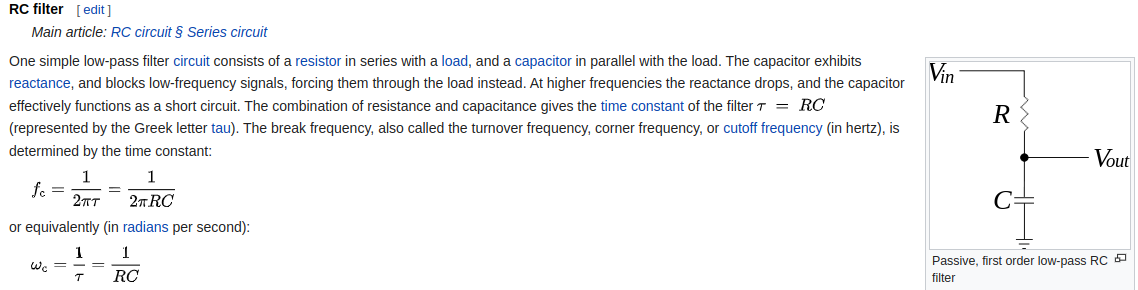

https://en.wikipedia.org/wiki/Low-pass_filter